# Quantum RNG

> 2019-04-19

This document investigates the possibility of implementing a verifiable random number generator on the IBM quantum processor.

In [1]:
from collections import Counter
import qiskit as Q
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Simply generating (theoretically unbiased) random bits on a quantum processor is rather trivial; a simple circuit like the one below will suffice:

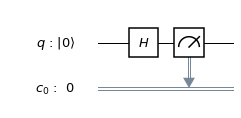

In [2]:
q = Q.QuantumRegister(1, 'q')
c = Q.ClassicalRegister(1, 'c')
qc = Q.QuantumCircuit(q, c)
qc.h(q[0])
qc.measure(q[0], c[0])
qc.draw(output='mpl')

What is perhaps more interesting is the possibility of verifying the randomness of the generator. Classically, this is a tricky problem; even after many statistical tests are applied to the generator's output, it is impossible to say whether the generator is random. This is because a classical definition of randomness is a statistical property based on the incompleteness of knowledge about a system. However, quantum mechanics is an inherently random theory, and as several papers ([Pironio et al.](https://arxiv.org/pdf/0911.3427.pdf), [Vazirani and Vidick[1]](https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.2011.0336), [Vazirani and Vidick[2]](https://people.eecs.berkeley.edu/~vazirani/pubs/dice0.pdf)) point out, it becomes possible to experimentally verify random properties of untrusted quantum generators through Bell violations.

We will use the Bell correlation estimator:

$$\hat{I} = \frac{1}{n} \sum _{x,y} (-1)^{xy} [N(a = b) - N(a \ne b)] / P(xy)$$

from the Pironio et al. We first construct a circuit to perform the measurements shown in Vazirani and Vidick\[1\].

In [3]:
# first stage: prepare a Bell pair
q = Q.QuantumRegister(2, 'q')
c = Q.ClassicalRegister(2, 'c')
prepare = Q.QuantumCircuit(q, c)
prepare.h(q[0])
prepare.cx(q[0], q[1])

# second stage: measure in appropriate bases described by x,y
def measure(x, y):
    set_bases = Q.QuantumCircuit(q, c)
    
    if x == 0:
        # measure first qubit in 0 basis
        set_bases.iden(q[0])
    else:
        # measure first qubit in pi/4 basis
        set_bases.u3(np.pi/2, np.pi, np.pi, q[0])
    if y == 0:
        # measure second qubit in pi/8 basis
        set_bases.u3(np.pi/4, np.pi, np.pi, q[1])
    else:
        # measure second qubit in -pi/8 basis
        set_bases.u3(-np.pi/4, np.pi, np.pi, q[1])
    
    set_bases.measure(q, c)
    return set_bases

We can try the simulation by providing an artificial sequence of (x,y) pairs:

In [4]:
xy = [(x,y) for x in (0,1) for y in (0,1)]
N = 1024
n = len(xy) * N
I = 0

# in this simulation, we will just do all equivalent (x,y)
# pairs at once for concision
for x, y in xy:
    circuit = prepare + measure(x, y)
    backend = Q.BasicAer.get_backend('qasm_simulator')
    job = Q.execute(circuit, backend, shots=N)
    result = Counter(job.result().get_counts(circuit))
    I += (-1) ** (x * y) * (result['00'] + result['11'] - result['01'] - result['10']) * 4
print(I / n)

2.8984375


As expected, the result is greater than 2, which suggests that something nonlocal is going on here.

We can now write our random number generator! The tricky part about this generator is that we need to provide it with some seed in order for it to start working, but I believe this seed can be much more biased than the output? I'm not quite sure how this works, but the Vazirani and Vidick\[2\] has a nice discussion of this.

In [5]:
# generate 2n random bits
# returns:
#   output, the random bits as a string of '0's and '1's
#   corr, the Bell correlation number
#   p, the p-value for corr > 2 with a uniform local model
def rng(n):
    # we will cheat a bit by seeding the algorithm with numpy
    xy = zip(np.random.randint(0, 2, n),
             np.random.randint(0, 2, n))
    results = {'00': Counter(), '01': Counter(),
               '10': Counter(), '11': Counter()}
    output = []

    # run trials over all (x,y)
    for x, y in xy:
        circuit = prepare + measure(x, y)
        backend = Q.BasicAer.get_backend('qasm_simulator')
        job = Q.execute(circuit, backend, shots=1)
        trial = Counter(job.result().get_counts(circuit))
        results['%d%d' % (x, y)] += trial
        output += list(trial.keys())[0]

    # statistically verify the randomness of the output
    # p-value is computed as shown in A.D3 Pironio et al.
    corr = 0
    for key, val in results.items():
        x, y = map(int, key)
        bell = val['00'] + val['11'] - val['01'] - val['10']
        freq = sum(val.values()) / n
        corr += (-1) ** (x * y) * bell / freq
    corr /= n
    p = np.exp(-n * (corr - 2) ** 2 / 72)

    return ''.join(output), corr, p

bits, corr, p = rng(1000)

In [6]:
bits

'110111111111011111110101101000001010101000000010111111111111111101010101001000000000001010000010000000000000000011111111111111110101111100100000001000101000000000000000000000001111110100100000100010101111111100000000000000100000000000100010000000101111010101110111000000000101010100000000000000001000001000000000101010101010001000000000111111111101111100100000111101111111111110000010101010101111111101010101000000100111111111110111110101010000000011011111000000001101110100000000111111011111011111111111111111011000001000000000111111110111111101010101111101110000100001111111000000000111111110101010011101110000000000100010000000001101111101111101000010100101111100101010101010101010101010101010111111110010000000001000000000100101010101010101000010000000100011011111111111011010101011110111000010000000000011110101010101010101110100001010111111111101110100100000111101111010100000100000000000001000000000000000000000000000000011011111110111111010101010001000111111010000000011111111111111111111111

Granted, I don't think this is the sort of thing one might wish to use quantum cloud computation for (after all, the sender could just fake the results of the Bell test), but it seems like an cool exercise.

Interestingly, when I run the statistical test suite from [here](http://www.fourmilab.ch/random/), it seems to fail the chi-square test with a p-value < 0.01 (closer to 0.5 is better). It is likely that I have an implementation error somewhere, although I'm not sure where. (Or I just converted the numbers to bits incorrectly.)